# **Test integration of DP Langevin**

Simple Jupyter notebook testing an adaptation of the Villa Martín/Buendía (VMB)
implementation of the Dornic et al (2005) method of integrating DP/APT-type
Langevin equations using an operator-splitting method. Access to the heavily 
refactored VMB C++ code is provided via a pybind11 wrapper.

See the main README for references.

<hr>

## Preliminaries

In [1]:
from typing import Any, Sequence, Callable
import numpy as np
from numpy.typing import NDArray
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import ticker
from matplotlib.colors import ListedColormap, Colormap
# import sys, os
# sys.path.insert(0, os.path.join(os.path.pardir, "build"))
import dplvn
import initialize

font_size = 11
font_family = "Arial"
try:
    mpl.rc("font", size=font_size, family=font_family)
except:
    mpl.rc("font", size=font_size, family="")

In [2]:
density_dict: dict[float, NDArray] = {}
fig_dict: dict[str, Any] = {}
density_image_dict: dict[int, Any] = {}
bold = lambda str: ("\033[1m" + str + "\033[0m")

<hr>

## `dplvn` info

In [3]:
print(f"dplvn version:  {dplvn.__version__}")

dplvn version:  2025.10.04a0


In [4]:
help(dplvn)

Help on module dplvn:

NAME
    dplvn - Operator-splitting method of integrating DP-type Langevin equations

CLASSES
    pybind11_builtins.pybind11_object(builtins.object)
        BoundaryCondition
        GridDimension
        GridTopology
        InitialCondition
        IntegrationMethod
        SimDP

    class BoundaryCondition(pybind11_builtins.pybind11_object)
     |  Method resolution order:
     |      BoundaryCondition
     |      pybind11_builtins.pybind11_object
     |      builtins.object
     |
     |  Methods defined here:
     |
     |  __eq__(...)
     |      __eq__(self: object, other: object, /) -> bool
     |
     |  __getstate__(...)
     |      __getstate__(self: object, /) -> int
     |
     |  __hash__(...)
     |      __hash__(self: object, /) -> int
     |
     |  __index__(...)
     |      __index__(self: dplvn.BoundaryCondition, /) -> int
     |
     |  __init__(...)
     |      __init__(self: dplvn.BoundaryCondition, value: typing.SupportsInt) -> None
     

In [5]:
help(dplvn.SimDP)

Help on class SimDP in module dplvn:

class SimDP(pybind11_builtins.pybind11_object)
 |  Method resolution order:
 |      SimDP
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(...)
 |      __init__(self: dplvn.SimDP, linear: typing.SupportsFloat = 1.0, quadratic: typing.SupportsFloat = 2.0, diffusion: typing.SupportsFloat = 0.1, noise: typing.SupportsFloat = 1.0, t_final: typing.SupportsFloat = 100.0, dx: typing.SupportsFloat = 0.5, dt: typing.SupportsFloat = 0.01, random_seed: typing.SupportsInt = 1, grid_dimension: dplvn.GridDimension = <GridDimension.D2: 2>, grid_size: collections.abc.Sequence[typing.SupportsInt] = [0, 0, 0, 0], grid_topology: dplvn.GridTopology = <GridTopology.BOUNDED: 1>, boundary_condition: dplvn.BoundaryCondition = <BoundaryCondition.FLOATING: 1>, initial_condition: dplvn.InitialCondition = <InitialCondition.RANDOM_UNIFORM: 1>, integration_method: dplvn.IntegrationMethod = <IntegrationMethod.RUNGE_KU

<hr>

## Demo

Perform demo integration of a DP Langevin on a 12 $\times$ 8 grid 
(96 cells) with simple choices of parameters.

In [6]:
sim = dplvn.SimDP(
    linear=1.0, quadratic=2.0, diffusion=0.1, noise=1.0, 
    t_final=20.0-1e-10, 
    # t_final=1e4-1e-10, 
    dx=0.5, dt=0.01,
    random_seed=1,
    # grid_dimension=dplvn.D1,
    # grid_size=(4096,),
    grid_dimension=dplvn.D2,
    grid_size=(12,8,),
    # grid_size=(40,20,),
    grid_topology=dplvn.BOUNDED,
    boundary_condition=dplvn.FLOATING,
    initial_condition=dplvn.RANDOM_UNIFORM,
    integration_method=dplvn.RUNGE_KUTTA
)

linear: 1
quadratic: 2
diffusion: 0.1
noise: 1
t_final: 20
dx: 0.5
dt: 0.01
random_seed: 1
grid_dimension: 2d
grid_size: 12 8 
n_cells: 96
grid_topology: bounded
boundary_condition: floating
initial_condition: random uniform values
integration_method: Runge-Kutta


In [7]:
if not sim.initialize():
    raise Exception("Failed to initialize sim")
n_epochs: int = sim.get_n_epochs()
print(f"Number of sim epochs = {n_epochs}")

Number of sim epochs = 2001


In [8]:
n_segments: int = 5
n_segment_epochs: int = (n_epochs-1) // n_segments
if (n_segment_epochs*n_segments+1)!=n_epochs:
    raise Exception(
        f"Failed to segment sim with {n_epochs} epochs "
        + "into {n_segments} segment(s)"
    )

In [9]:
for i_segment in range(0, n_segments+1, 1):
    if i_segment>0 and not sim.run(n_segment_epochs):
        raise Exception("Failed to run sim")
    if not sim.postprocess():
        raise Exception("Failed to process sim results")
    i_epoch = sim.get_i_current_epoch()
    t_epoch = np.round(sim.get_t_current_epoch())
    density_dict[t_epoch] = sim.get_density()
    print(bold(
        f"segment={i_segment}/{n_segments}  "
        + f"i={i_epoch} t={t_epoch}"
    ))
    # print(f"t epochs:  {sim.get_t_epochs()}")
    # print(f"mean densities:  {sim.get_mean_densities()}")
    # print("cell density grid:")
    print(np.round(density_dict[t_epoch].T, 2), flush=True)
    # print(flush=True)

segment=0/5  i=0 t=0.0
[[1.   0.93 0.13 1.   0.24 0.4  0.39 0.67 0.94 0.85 0.31 0.52]
 [0.44 0.23 0.53 0.91 0.46 0.43 0.94 0.78 0.72 0.8  0.09 0.52]
 [0.87 0.83 0.83 0.27 0.06 0.67 0.59 0.67 0.41 0.2  0.29 0.14]
 [0.78 0.41 0.03 0.62 0.66 0.3  0.45 0.22 0.07 0.47 0.1  0.9 ]
 [0.12 0.52 0.08 0.92 0.91 0.3  0.58 0.57 0.61 0.96 0.26 0.23]
 [0.53 0.95 0.49 0.54 0.77 0.05 0.14 0.79 0.03 0.88 0.54 0.45]
 [0.89 0.38 0.54 0.65 0.36 0.57 0.64 0.13 0.69 0.65 0.35 0.76]
 [0.36 0.75 0.88 0.01 0.5  0.07 0.79 0.06 0.36 0.94 0.38 0.76]]
segment=1/5  i=400 t=4.0
[[0.63 0.21 0.09 0.1  0.13 0.25 0.43 1.01 0.83 0.17 0.22 0.  ]
 [0.46 0.41 0.01 0.33 0.78 0.25 1.02 0.79 0.16 0.43 0.84 0.04]
 [0.13 0.   0.02 0.08 0.24 0.17 0.39 0.59 0.4  0.25 0.16 0.03]
 [0.   0.02 0.33 0.16 0.45 0.02 0.15 0.41 0.15 0.67 0.07 0.01]
 [0.4  0.5  0.   0.   0.25 0.   0.32 0.13 0.49 0.68 0.32 0.26]
 [0.18 0.05 0.57 0.15 0.51 0.36 0.49 0.54 0.11 0.23 0.55 0.34]
 [0.01 0.09 0.42 0.19 0.62 0.39 0.13 0.02 0.46 0.4  0.   0.44]
 [0.  

Simulation results are returned as a `numpy` array with integration time steps
("epochs") in the first column and grid-mean density ("mean_densities") in the
second column. 

In [10]:
t_epochs: NDArray = sim.get_t_epochs()
mean_densities: NDArray = sim.get_mean_densities()
t_epochs[-10:], mean_densities[-10:]

(array([19.91, 19.92, 19.93, 19.94, 19.95, 19.96, 19.97, 19.98, 19.99,
        20.  ]),
 array([0.20525297, 0.20997552, 0.21436799, 0.21437968, 0.21062611,
        0.21314307, 0.21629077, 0.21165195, 0.20919399, 0.20818068]))

<hr>

## Plot

In [11]:
def plot_density_image(t_epoch: float, density: NDArray,):
    fig = plt.figure(figsize=(5, 5,))
    (n_x, n_y,) = density.shape
    color_palette: str = "inferno_r"
    color_map: Colormap = plt.get_cmap(color_palette) #type: ignore
    plt.imshow(
        np.flipud(density.T),  extent=(0, n_x, 0, n_y), cmap=color_map,
    )
    ticks: NDArray = np.arange(0, 5, 0.5,)
    color_bar: Any = plt.colorbar(
        shrink=0.35, pad=0.05, aspect=8, ticks=ticks,
    )
    color_bar.set_label(r"$\rho(\mathbf{x},t)$  [-]")
    plt.title(r"density  $\rho(\mathbf{x},t=$" + f"{t_epoch:g}" + r"$)$")
    plt.xlabel(r"$x$   [-]")
    plt.ylabel(r"$y$   [-]")
    plt.close()
    return fig

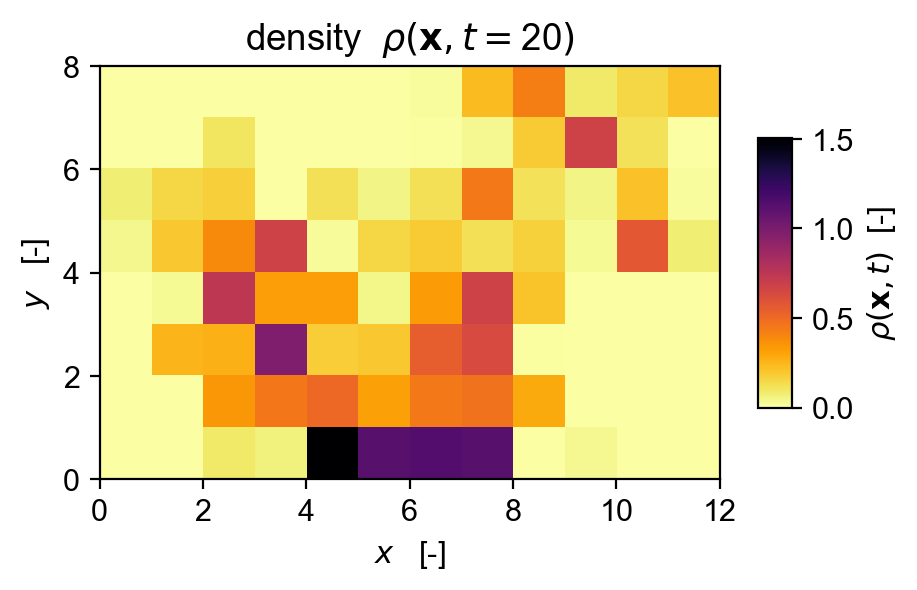

In [12]:
for i_epoch_, t_epoch_ in enumerate(density_dict.keys()):
    density_ = density_dict[t_epoch_]
    density_image_dict[i_epoch_] = plot_density_image(t_epoch_, density_)
density_image_dict[n_segments]

Plot the time-series of grid-averaged density field.

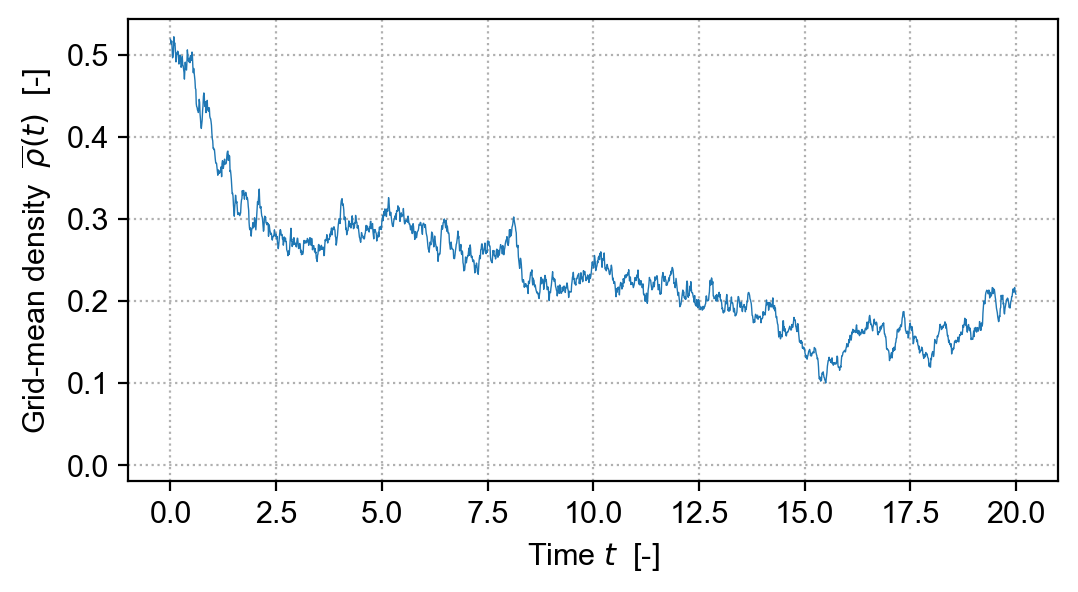

In [13]:
fig_dict.update({"meandensity_time": plt.figure(figsize=(6, 3,))})
plt.plot(t_epochs, mean_densities, "-", lw=0.5,)
plt.xlabel(r"Time $t$  [-]")
plt.ylabel(r"Grid-mean density  $\overline{\rho}(t)$  [-]")
plt.ylim(-0.02, None)
plt.grid(ls=":")

<hr>

## Save

In [14]:
for fig_ in fig_dict.keys():
    fig_name_ = f"{fig_}.png"
    print(fig_name_)
    fig_dict[fig_].savefig(
        fig_name_,
        bbox_inches="tight",
        pad_inches=0.05,
        dpi=150,
        format="PNG",
    )

meandensity_time.png


In [15]:
fig_name_ = "density_grid.png"
print(fig_name_)
density_image_dict[n_segments].savefig(
    fig_name_,
    bbox_inches="tight",
    pad_inches=0.05,
    dpi=150,
    format="PNG",
)

density_grid.png
